In [1]:
#Import packages

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

from matplotlib import pyplot as plt

#torchvision.datasets.ImageNet('imagenet')

In [2]:
#Load the MNIST dataset

(X_train, y_train), (X_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

#Swap axes to PyTorch's NCHW format

x_train = np.transpose(X_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(X_test, (0, 3, 1, 2)).astype(np.float32)

In [3]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
  
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
  
# DataLoader is used to load the dataset 
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)

In [4]:
#Plot MNIST image function
def plot_mnist_img(image):
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [5]:
print(f"Autoencoder dataset: {type(x_train)}, {x_train.shape}.")
print(f"Autoencoder input: {type(x_train[0])}, {x_train[0].shape}.")
for (image, _) in loader:
    print(f"Classification subset: {type(image)}, {image.stride()}.")
    print(f"Classification inputs: {type(image[0])}, {image[0].stride()}.")
    modified_img = image[0].detach().numpy()
    modified_np = torch.from_numpy(x_train[0])
    print(f"Autoencoder modification: {modified_np.stride()}.")
    print(f"Classification modification: {modified_img.shape}.")
    break

Autoencoder dataset: <class 'numpy.ndarray'>, (60000, 1, 28, 28).
Autoencoder input: <class 'numpy.ndarray'>, (1, 28, 28).
Classification subset: <class 'torch.Tensor'>, (784, 784, 28, 1).
Classification inputs: <class 'torch.Tensor'>, (784, 28, 1).
Autoencoder modification: (784, 28, 1).
Classification modification: (1, 28, 28).


Epochs: 1/3
Epochs: 2/3
Epochs: 3/3


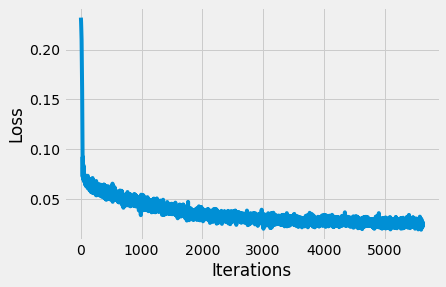

In [6]:
#Initialize autoencoder class

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.PReLU(),
            nn.Linear(128, 64),
            nn.PReLU(),
            nn.Linear(64, 36),
            nn.PReLU(),
            nn.Linear(36, 18),
            nn.PReLU(),
            nn.Linear(18, 9),
        )
          
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            nn.Linear(9, 18),
            nn.PReLU(),
            nn.Linear(18, 36),
            nn.PReLU(),
            nn.Linear(36, 64),
            nn.PReLU(),
            nn.Linear(64, 128),
            nn.PReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Step 2: Create the model

model = Autoencoder()
  
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

# Step 3: Create the ART classifier

epochs = 3
outputs = []
losses = []
for epoch in range(epochs):
    for (image, _) in loader:
        
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss)
        
    outputs.append((epochs, image, reconstructed))
    print(f"Epochs: {epoch+1}/{epochs}")

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses)

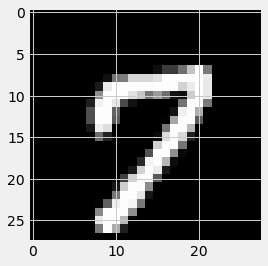

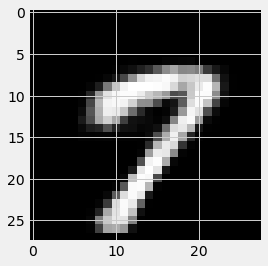

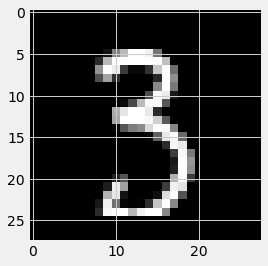

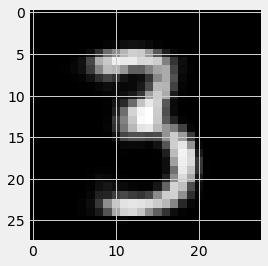

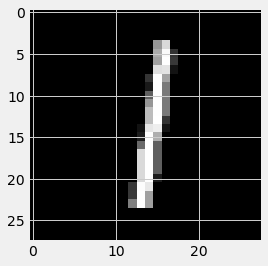

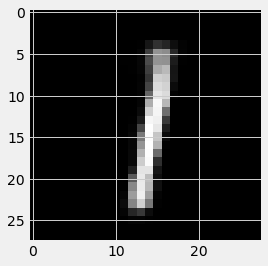

In [8]:
count = 0
for (image, _) in loader:
    image = image.reshape(-1, 28*28)
    decoded_image = model(image[0])
    plot_mnist_img(image[0].detach().numpy())
    plot_mnist_img(decoded_image.detach().numpy())
    count +=1
    if count == 3:
        break

In [9]:
#Generate Net class

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x



# Step 2: Create the model

model_clf = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model_clf,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

"""
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))
"""


Accuracy on benign test examples: 6.2700000000000005%


'\n# Step 6: Generate adversarial test examples\nattack = FastGradientMethod(estimator=classifier, eps=0.2)\nx_test_adv = attack.generate(x=x_test)\n\n# Step 7: Evaluate the ART classifier on adversarial test examples\n\npredictions = classifier.predict(x_test_adv)\naccuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)\nprint("Accuracy on adversarial test examples: {}%".format(accuracy * 100))\n'

In [29]:
def manifold_attack(classifier, X, autoencoder, epsilon=0.3):
    max_iters = 40
    result = []
    y_pred = classifier.predict(X)
    y_pred_class = np.argmax(y_pred, axis=1)
    #Loop through instances
    for i,x in enumerate(X):
        image = x.reshape(-1, 28*28)
        x_enc = autoencoder.encoder(image)
        size = len(x_enc[0])
        canAdd = True
        #Try different possible attack combinantions
        for j in range(max_iters):
            #Get random attack
            delta_aux = np.random.normal(size=size)
            delta_aux_norm = np.sqrt((delta_aux**2).sum())
            delta = epsilon*np.random.uniform(1)*delta_aux/delta_aux_norm
            x_attack_enc = x_enc + torch.from_numpy(delta)
            x_attack = autoencoder.decoder(x_attack_enc.to(torch.float))
            x_attack_np = x_attack.detach().numpy()
            image = x_attack_np.reshape((28,28))
            #Check if attack changes classifier prediction
            y_pred_attack = classifier.predict([[image]])
            y_pred_attack_class = np.argmax(y_pred_attack)
            if not y_pred_class[i] != y_pred_attack_class:
                result.append([image])
                canAdd = False
                break
        if canAdd:
            result.append([image])
    return result
            

In [41]:
#Get train attack set
x_attack_set = []
y_attack_set = []
for epoch in range(epochs):
    for (image, y) in loader:
        x_attack = manifold_attack(classifier, image, model)
        x_attack_set.append(x_attack)
        y_attack_set.append(y)
    print(f"Epochs: {epoch+1}/{epochs}")


Epochs: 1/3
Epochs: 2/3
Epochs: 3/3


In [42]:
#Get test attack set
x_attack_test_set = []
y_attack_test_set = []
for (image, y) in loader:
    x_attack = manifold_attack(classifier, image, model)
    x_attack_test_set.append(x_attack)
    y_attack_test_set.append(y)

In [46]:
#Function to measure accuracy
def measure_accuracy(classifier, X, Y):
    acc_test = 0
    for i in range(len(X)):
        pred_y = classifier.predict(X[i])
        pred_y_class = np.argmax(pred_y,axis=1)
        y_np = Y[i].detach().numpy()
        acc_test += (pred_y_class==y_np).sum()
    acc_test = acc_test/(len(attack_test_set)*len(attack_test_set[0][1]))
    return acc_test
    

In [47]:
#Check accuracy in test set without training
acc_attack_test = measure_accuracy(classifier, x_attack_test_set, y_attack_test_set)
print(f"Accuracy of model before training in manifold attack is: {acc_attack_test*100}%")

Accuracy of model before training in manifold attack is: 7.261666666666667%


In [62]:
#Training in manifold attack
print(x_attack_set.shape)
print(x_train.shape)

(5625, 32, 1, 28, 28)
(60000, 1, 28, 28)
